# Jet Substructure

## Load libraries and input files

In this notebook, we will load different files from different process. This can take some time:

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import hist
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import correctionlib
import copy

plt.style.use(hep.style.CMS)
plt.rcParams.update({
    'font.size': 16,         # Base font size
    'axes.titlesize': 18,    # Title font size
    'axes.labelsize': 16,    # Axis label font size
    'xtick.labelsize': 14,   # X-tick label size
    'ytick.labelsize': 14,   # Y-tick label size
    'legend.title_fontsize': 16, # Legend title size
    'legend.fontsize': 16        # Legend font size
})

In [2]:
fname_qcd = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/jets/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/20UL18JMENano_106X_upgrade2018_realistic_v16_L1v1-v1/30000/792B4CD3-A001-F94F-9AAB-D74D532DE610.root"
fname_ttbar = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/jets/RunIISummer20UL18NanoAODv9/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2520000/130AF209-596A-BA46-BA9E-D8847511BB0F.root"
fname_rsgluon = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/jets/RunIISummer20UL18NanoAODv9/RSGluonToTT_M-1000_TuneCP5_13TeV-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/130000/F2DC937C-90D2-CF40-9FCA-017BB8CD7B9E.root"
fname_wjets = "root://eosuser.cern.ch//eos/user/c/cmsdas/2025/RunIISummer20UL18NanoAODv9/WJetsToQQ_HT-800toInf_TuneCP5_13TeV-madgraphMLM-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v2/2550000/1651E9BC-5EFF-E149-A1C1-019EAA144F5E.root"

events_qcd = NanoEventsFactory.from_root( fname_qcd, schemaclass=NanoAODSchema.v6).events()
events_ttbar = NanoEventsFactory.from_root( fname_ttbar, schemaclass=NanoAODSchema.v6).events()
events_rsgluon = NanoEventsFactory.from_root( fname_rsgluon, schemaclass=NanoAODSchema.v6).events()
events_wjets = NanoEventsFactory.from_root( fname_wjets, schemaclass=NanoAODSchema.v6).events()

## Exercise 4.1: Jet Mass

Let's look a the different jet mass distributions for different processes:

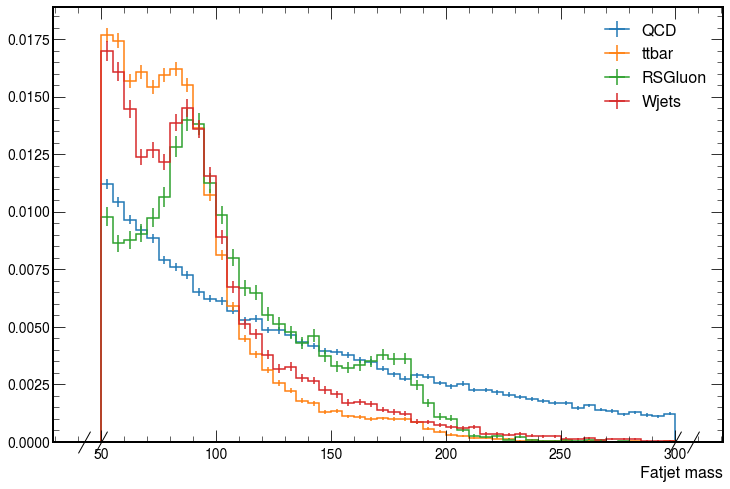

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

hists_mass = (
    hist.Hist.new
    .StrCat(["QCD", "ttbar", "RSGluon", "Wjets"], name="dataset")
    .Reg(50, 50, 300, name="mass", label='Fatjet mass')
    .Weight()
    .fill(
        dataset='QCD',
        mass=ak.flatten( events_qcd.FatJet.mass ),
    )
    .fill(
        dataset='ttbar',
        mass=ak.flatten( events_ttbar.FatJet.mass ),
    )
    .fill(
        dataset='RSGluon',
        mass=ak.flatten( events_rsgluon.FatJet.mass ),
    )
    .fill(
        dataset='Wjets',
        mass=ak.flatten( events_wjets.FatJet.mass ),
    )
).plot1d(density=True)

ax.legend()
# ax.set_yscale("log")

## Exercise 4.2: Jet Grooming algorithms

Let's make a plot comparing the ungroomed mass and the softdrop mass:

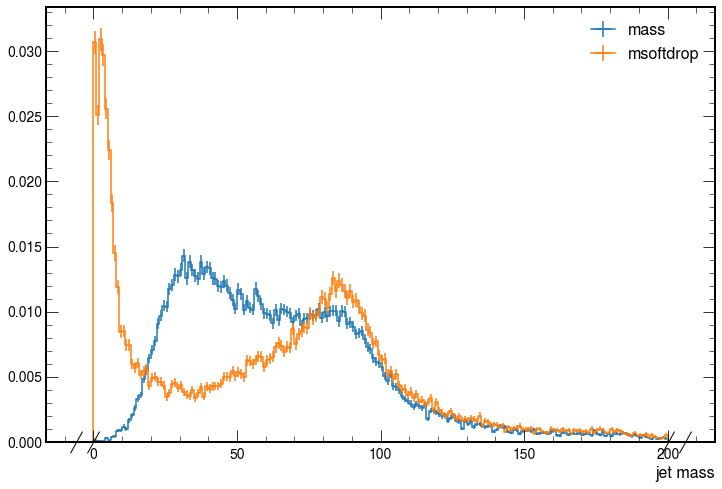

In [7]:
hists_mass = (
    hist.Hist.new
    .StrCat(["mass", "msoftdrop"], name="mass_type")
    .Reg(200, 0, 200, name="mass", label='jet mass')
    .Weight()
    .fill(
        mass_type='mass',
        mass=ak.flatten(events_ttbar.FatJet.mass),
    )
    .fill(
        mass_type='msoftdrop',
        mass=ak.flatten(events_ttbar.FatJet.msoftdrop),
    )
)
fig, ax = plt.subplots(figsize=(12, 8))
hists_mass.plot1d(density=True)
ax.legend()

### $\rho$ parameter

Let's create this variable and make some comparison plots:

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(


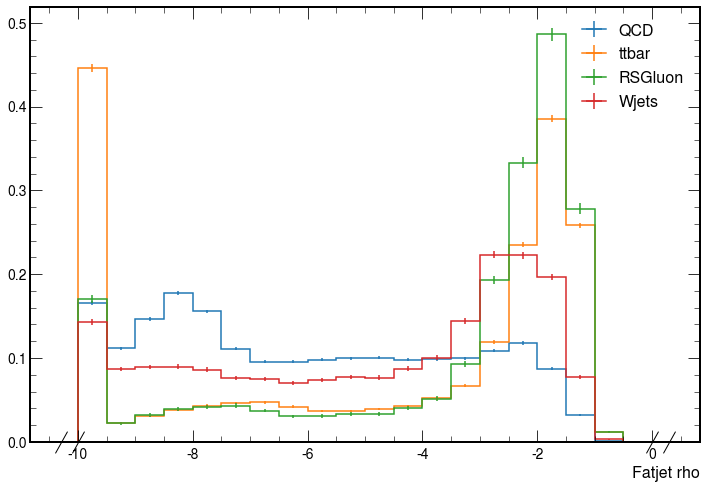

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

hists_rho = (
    hist.Hist.new
    .StrCat(["QCD", "ttbar", "RSGluon", "Wjets"], name="dataset")
    .Reg(20, -10, 0, name="rho", label='Fatjet rho')
    .Weight()
    .fill(
        dataset='QCD',
        rho=ak.flatten( np.log( np.power( events_qcd.FatJet.msoftdrop / (events_qcd.FatJet.pt * 0.8) , 2 ) ) ),
    )
    .fill(
        dataset='ttbar',
        rho=ak.flatten(np.log( np.power( events_ttbar.FatJet.msoftdrop / (events_ttbar.FatJet.pt * 0.8) , 2 ) ) ),
    )
    .fill(
        dataset='RSGluon',
        rho=ak.flatten(np.log( np.power( events_rsgluon.FatJet.msoftdrop / (events_rsgluon.FatJet.pt * 0.8) , 2 ) ) ),
    )
    .fill(
        dataset='Wjets',
        rho=ak.flatten(np.log( np.power( events_wjets.FatJet.msoftdrop / (events_wjets.FatJet.pt * 0.8) , 2 ) ) ),
    )
).plot1d(density=True)

ax.legend()

## Exercise 4.2: Substructure Variables

Now, let's compare the different subtructure variables between different samples:

In [10]:
def create_substructure_variables( jets ):
    
    jets['tau21'] = jets.tau2 / jets.tau1
    jets['tau32'] = jets.tau3 / jets.tau2

    return jets

In [11]:
jets_qcd = create_substructure_variables( events_qcd.FatJet )
jets_ttbar = create_substructure_variables( events_ttbar.FatJet )
jets_rsgluon = create_substructure_variables( events_rsgluon.FatJet )
jets_wjets = create_substructure_variables( events_wjets.FatJet )

/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [12]:
hists = (
    hist.Hist.new
    .StrCat(["QCD", "ttbar", "RSGluon", "Wjets"], name="dataset")
    .Reg(200, 0, 2000, name="pt", label='Fatjet pt')
    .Reg(10, 0, 1, name="tau21", label='Fatjet tau21')
    .Reg(10, 0, 1, name="tau32", label='Fatjet tau32')
    .Reg(20, 0, 1, name="n2", label='Fatjet N2')
    .Reg(20, 0, 1, name="n3", label='Fatjet N3')
    .Weight()
    .fill(
        dataset='QCD',
        pt=ak.flatten(jets_qcd.pt),
        tau21=ak.flatten(jets_qcd.tau21),
        tau32=ak.flatten(jets_qcd.tau32),
        n2=ak.flatten(jets_qcd.n2b1),
        n3=ak.flatten(jets_qcd.n3b1),
    )
    .fill(
        dataset='ttbar',
        pt=ak.flatten(jets_ttbar.pt),
        tau21=ak.flatten(jets_ttbar.tau21),
        tau32=ak.flatten(jets_ttbar.tau32),
        n2=ak.flatten(jets_ttbar.n2b1),
        n3=ak.flatten(jets_ttbar.n3b1),
    )
    .fill(
        dataset='RSGluon',
        pt=ak.flatten(jets_rsgluon.pt),
        tau21=ak.flatten(jets_rsgluon.tau21),
        tau32=ak.flatten(jets_rsgluon.tau32),
        n2=ak.flatten(jets_rsgluon.n2b1),
        n3=ak.flatten(jets_rsgluon.n3b1),
    )
    .fill(
        dataset='Wjets',
        pt=ak.flatten(jets_wjets.pt),
        tau21=ak.flatten(jets_wjets.tau21),
        tau32=ak.flatten(jets_wjets.tau32),
        n2=ak.flatten(jets_wjets.n2b1),
        n3=ak.flatten(jets_wjets.n3b1),
    )
)

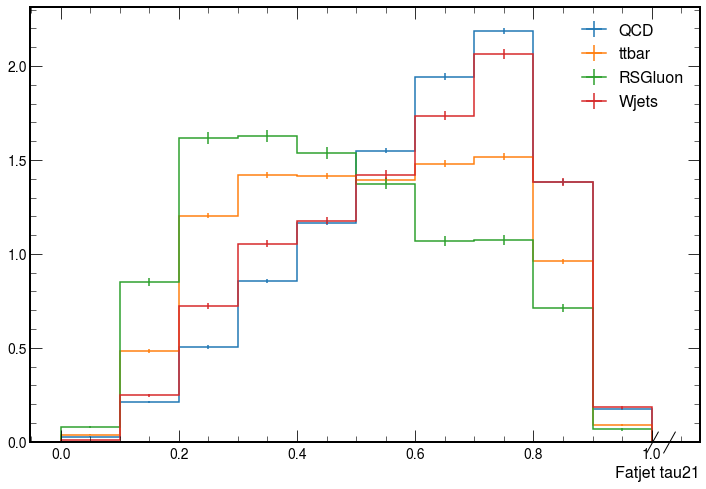

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))
hists.project("dataset", "tau21").plot1d(density=True)
ax.legend()

Let's do the same for tau32, but let's increase the jet pt to 450 GeV to enchance the efect:

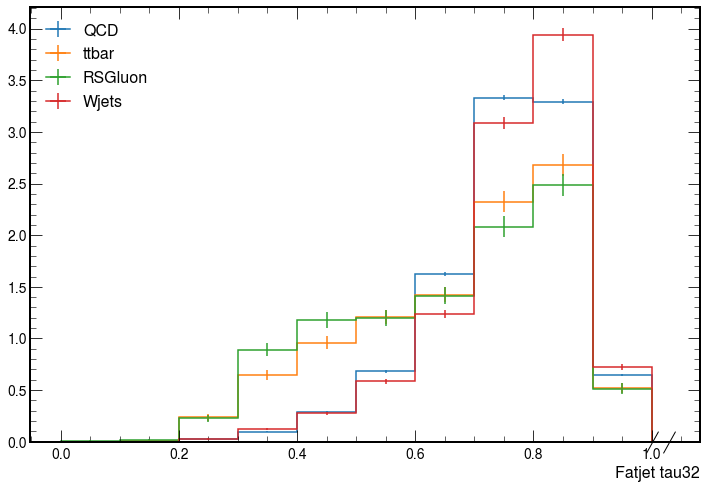

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
hists.project("dataset", "tau32", "pt")[:,:,450j::sum].plot1d(density=True)
ax.legend()

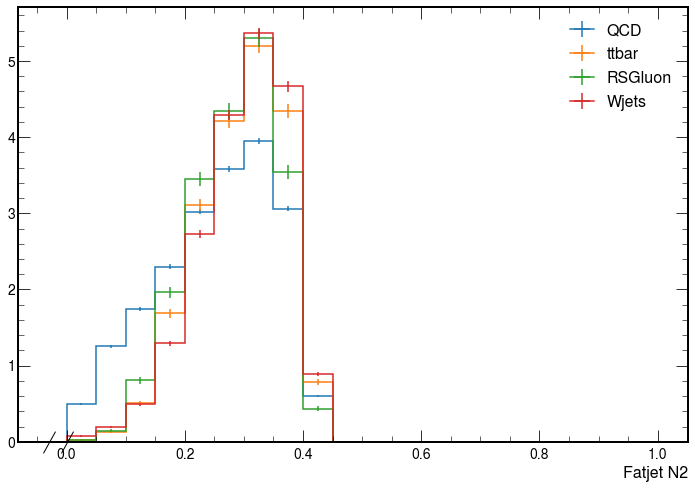

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
hists.project("dataset", "n2", "pt")[:,:,300j::sum].plot1d(density=True)
ax.legend()

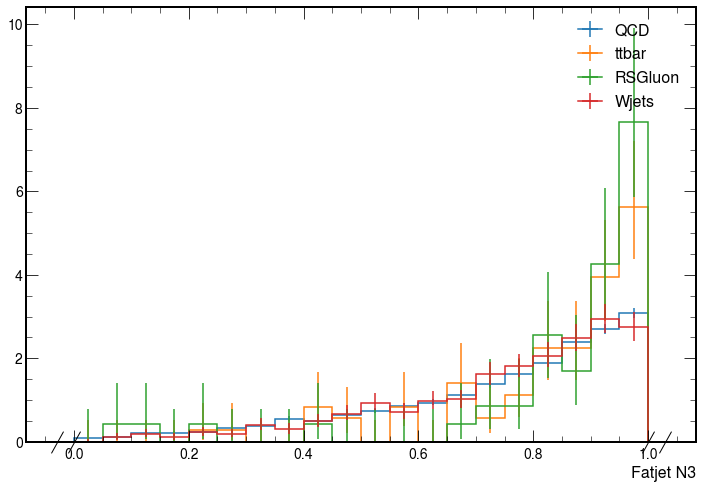

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
hists.project("dataset", "n3", "pt")[:,:,450j::sum].plot1d(density=True)
ax.legend()

## Exercise 4.4: Taggers

### W tagging

Let's compare the tau2 / tau1 ratio for the AK8 jets from Standard Model top quarks to those from the QCD sample:

In [18]:
hists_wtag = (
    hist.Hist.new
    .StrCat(["QCD", "ttbar"], name="dataset")
    .Reg(60, 0, 300, name="mass", label='Fatjet mass softdrop')
    .Reg(10, 0, 1, name="tau21", label='Fatjet tau21')
    .Reg(20, 0, 1, name="n2", label='Fatjet N2')
    .Reg(20, 0, 1, name="deepAK8_W", label='Fatjet deepAK8Jet W')
    .Weight()
    .fill(
        dataset='QCD',
        mass=ak.flatten(jets_qcd.msoftdrop),
        tau21=ak.flatten(jets_qcd.tau21),
        n2=ak.flatten(jets_qcd.n2b1),
        deepAK8_W=ak.flatten(jets_qcd.deepTagMD_WvsQCD),
    )
    .fill(
        dataset='ttbar',
        mass=ak.flatten(jets_ttbar.msoftdrop),
        tau21=ak.flatten(jets_ttbar.tau21),
        n2=ak.flatten(jets_ttbar.n2b1),
        deepAK8_W=ak.flatten(jets_ttbar.deepTagMD_WvsQCD),
    )
)

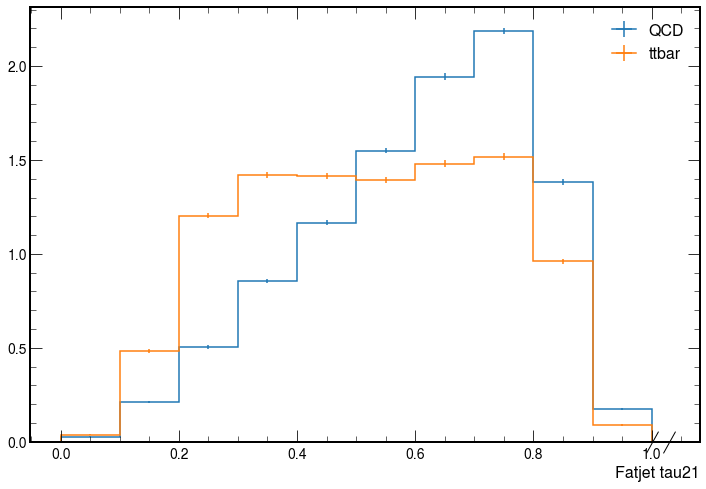

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "tau21").plot1d(density=True)
ax.legend()

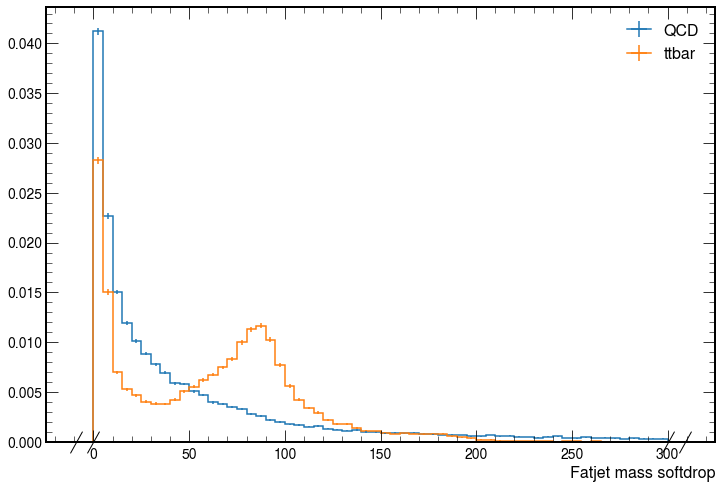

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "mass").plot1d(density=True)
ax.legend()

What happen if we apply a selection in tau21 of $<0.5$?

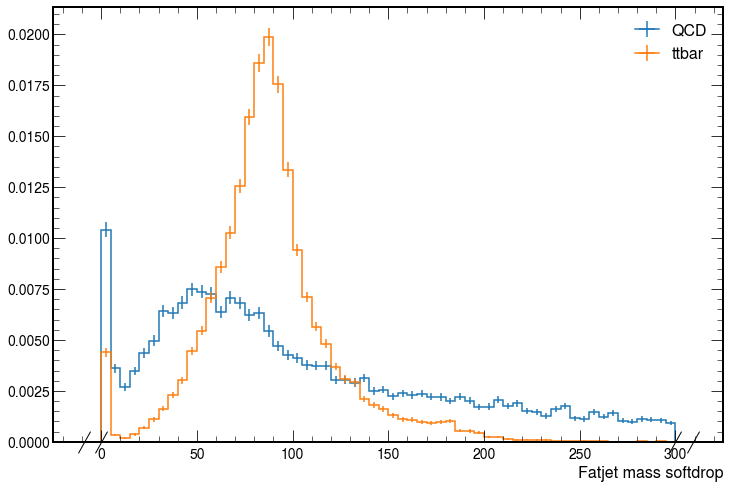

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "mass", "tau21")[:,:,:0.5j:sum].plot1d(density=True)
ax.legend()

Let's use now $N2$ with a selection of 0.2:

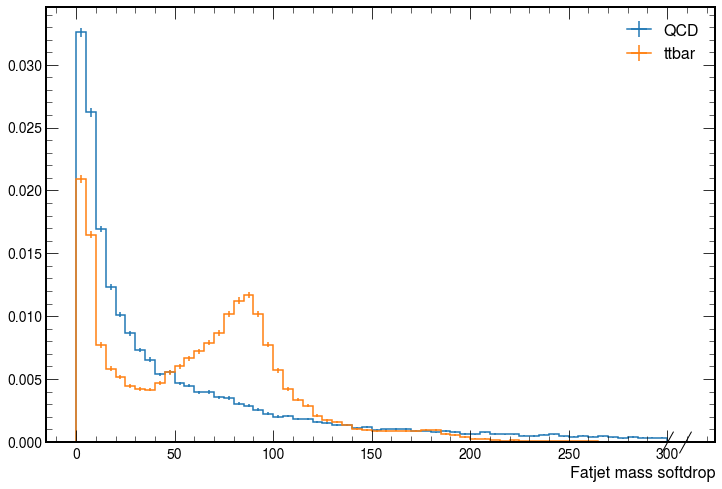

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "mass", "n2")[:,:,0.2j::sum].plot1d(density=True)
ax.legend()

CMS has developed taggers using ML techinques. Let's try deepAK8 Jet tagger for W jets:

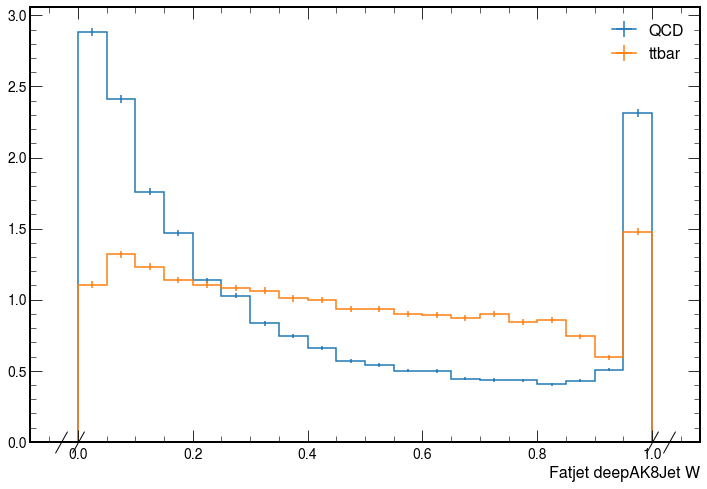

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "deepAK8_W").plot1d(density=True)
ax.legend()

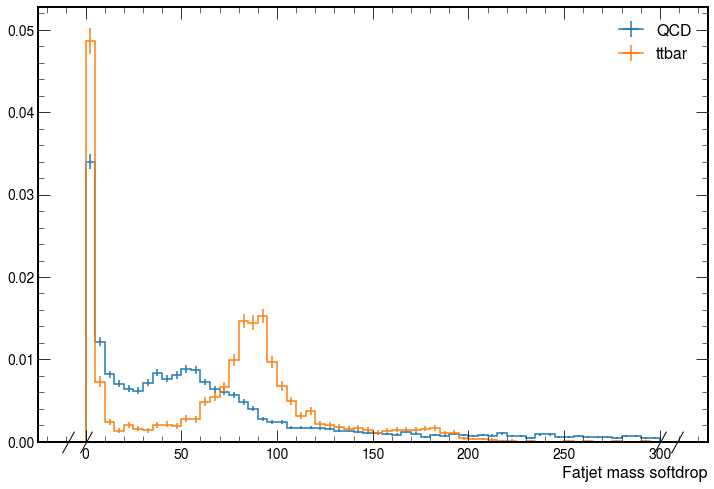

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_wtag.project("dataset", "mass", "deepAK8_W")[:,:,0.85j::sum].plot1d(density=True)
ax.legend()

### top tagging

Let's repeat the same exercise but now using the subtructure variables for top tagging:

In [25]:
hists_toptag = (
    hist.Hist.new
    .StrCat(["QCD", "ttbar"], name="dataset")
    .Reg(60, 0, 300, name="mass", label='Fatjet mass softdrop')
    .Reg(10, 0, 1, name="tau32", label='Fatjet tau32')
    .Reg(20, 0, 1, name="n3", label='Fatjet N3')
    .Reg(20, 0, 1, name="deepAK8_top", label='Fatjet deepAK8Jet top')
    .Weight()
    .fill(
        dataset='QCD',
        mass=ak.flatten(jets_qcd.msoftdrop),
        tau32=ak.flatten(jets_qcd.tau32),
        n3=ak.flatten(jets_qcd.n3b1),
        deepAK8_top=ak.flatten(jets_qcd.deepTagMD_TvsQCD),
    )
    .fill(
        dataset='ttbar',
        mass=ak.flatten(jets_ttbar.msoftdrop),
        tau32=ak.flatten(jets_ttbar.tau32),
        n3=ak.flatten(jets_ttbar.n3b1),
        deepAK8_top=ak.flatten(jets_ttbar.deepTagMD_TvsQCD),
    )
)

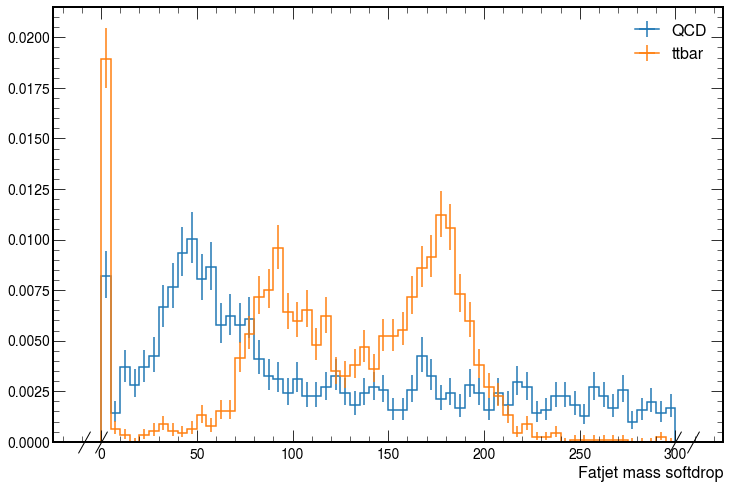

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_toptag.project("dataset", "mass", "tau32")[:,:,:0.5j:sum].plot1d(density=True)
ax.legend()

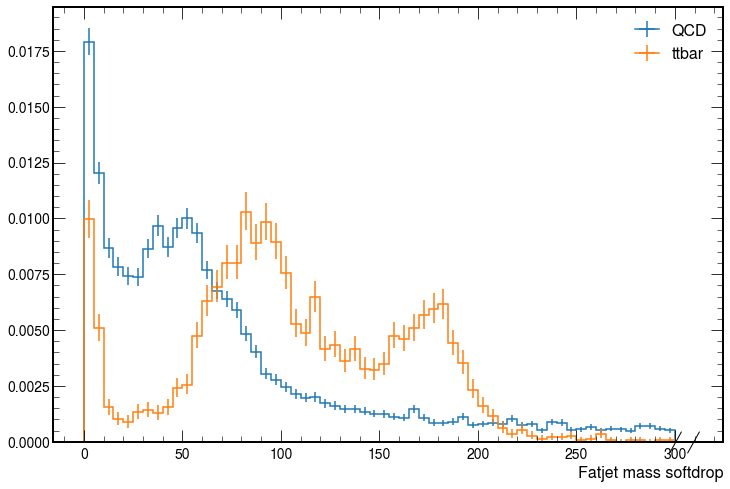

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
hists_toptag.project("dataset", "mass", "deepAK8_top")[:,:,0.85j::sum].plot1d(density=True)
ax.legend()

## Your turn

Now you can play with the subtructure variables and try to improve the jet mass distribution.